# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)

In [3]:
profile = pd.read_json('data/profile.json', orient='records', lines=True)

In [4]:
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1. Exploring and Preprocessing Data

## 1.1 Exploring and Preprocessing Offerings

In [5]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


#### First of all let encode the effer id to make it easier to manage (we will use the same encoder to transform the transcript data)

In [6]:
offer_encoder = LabelEncoder()
portfolio['o_id'] = offer_encoder.fit_transform(portfolio['id'])
portfolio


,reward,channels,difficulty,duration,offer_type,id,o_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,7
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,4
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,3
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,6
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,9
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,5
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,8
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,2


#### The channel column can't be used by model training as it is and we need to hot encode it to be useful

In [7]:
portfolio = portfolio.join(portfolio['channels'].str.join('|').str.get_dummies())

In [8]:
portfolio['offer_type_dummy'] = portfolio['offer_type']
portfolio = pd.get_dummies(portfolio, columns=['offer_type_dummy'], drop_first=False, prefix="offer_type")
portfolio

,reward,channels,difficulty,duration,offer_type,id,o_id,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,7,1,1,1,0,1,0,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,4,1,1,1,1,1,0,0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,3,1,1,0,1,0,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,6,1,1,0,1,1,0,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0,1,0,1,0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,1,0,1,0
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,9,1,1,1,1,0,1,0
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,5,1,1,1,0,0,0,1
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,8,1,1,1,1,1,0,0
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,2,1,1,0,1,0,1,0


In [9]:
# duration is in days we should convert it to hours to make it comparable with time in transcript
portfolio['duration_h'] = portfolio['duration'] * 24
portfolio

,reward,channels,difficulty,duration,offer_type,id,o_id,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational,duration_h
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,7,1,1,1,0,1,0,0,168
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,4,1,1,1,1,1,0,0,120
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,3,1,1,0,1,0,0,1,96
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,6,1,1,0,1,1,0,0,168
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0,1,0,1,0,240
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,1,0,1,0,168
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,9,1,1,1,1,0,1,0,240
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,5,1,1,1,0,0,0,1,72
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,8,1,1,1,1,1,0,0,120
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,2,1,1,0,1,0,1,0,168


## 1.2 Exploring and Preprocessing Customer Demographics

In [10]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


The dataset of portfolio is clean and doesn't have any missing value but profile dataset and transcript dataset can have missing value. We need to visualize how much missing data do we have



In [11]:
n_profile_records = profile.shape[0]
n_missing_records_profile = profile.shape[0] - profile.dropna().shape[0]
print(f"Total customers: {n_profile_records}")
print(f"Total Customer with Missing Data: {n_missing_records_profile}")
print(f"Precentage Missing Profile Data: {100*n_missing_records_profile/n_profile_records}")

profile.isnull().mean()

Total customers: 17000
Total Customer with Missing Data: 2175
Precentage Missing Profile Data: 12.794117647058824


gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

### 1.2.1 Hot encode Gender data as it contain more than two value

In [12]:
profile['gender'].unique()
profile["gender_old"] = profile['gender']
gender_encoder = LabelEncoder()
profile['gender']=gender_encoder.fit_transform(profile['gender'])

#### Converting `became_member_on` field to year, month and day

In [13]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['mem_year'] = profile['became_member_on'].dt.year
profile['mem_month'] = profile['became_member_on'].dt.month
profile['mem_day'] = profile['became_member_on'].dt.day

In [14]:
profile.head()

,gender,age,id,became_member_on,income,gender_old,mem_year,mem_month,mem_day
0,3,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,None,2017,2,12
1,0,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,F,2017,7,15
2,3,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,None,2018,7,12
3,0,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,F,2017,5,9
4,3,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,None,2017,8,4


In [15]:
#Function to visualize the data
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
def distribution(data, features):
    """
    Visualization code for displaying skewed distributions of features
    """ 
    
    fig = pl.figure(figsize = (11,5));

    # Skewed feature plotting
    for i, feature in enumerate(features):
        ax = fig.add_subplot(1, 2, i+1)
        ax.hist(data[feature], bins = 25, color = '#00A0A0')
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")
        ax.set_ylim((0, 2000))
        ax.set_yticks([0, 500, 1000, 1500, 2000, 2500])
        ax.set_yticklabels([0, 500, 1000, 1500, 2000, ">2500"])

    fig.suptitle("Skewed Distributions of Continuous Census Data Features", \
        fontsize = 16, y = 1.03)

    fig.tight_layout()
    fig.show()
    
   

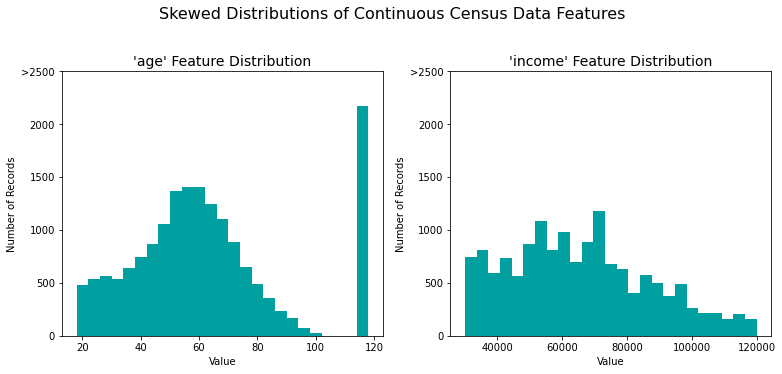

In [16]:
distribution(profile, ['age', 'income'])

The age is well distributed with one outlier value of *118*, it is safe to assume that this value is incorrect and can be considered missing


### 1.2.2 Cleaning age data and handling missing value = 118

In [17]:
# convert 118 to Nan
profile["age"].replace({118: np.nan}, inplace=True)

In [18]:
profile.isnull().mean()

gender              0.000000
age                 0.127941
id                  0.000000
became_member_on    0.000000
income              0.127941
gender_old          0.127941
mem_year            0.000000
mem_month           0.000000
mem_day             0.000000
dtype: float64

<AxesSubplot:>

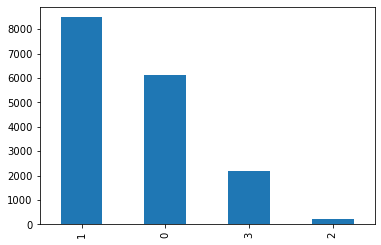

In [19]:
genders = profile['gender'].replace({None: 'U'})
genders.value_counts().plot(kind='bar')


Now lets look at the latest state of the demographics dataset

In [20]:
profile.head()

,gender,age,id,became_member_on,income,gender_old,mem_year,mem_month,mem_day
0,3,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,None,2017,2,12
1,0,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,F,2017,7,15
2,3,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,None,2018,7,12
3,0,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,F,2017,5,9
4,3,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,None,2017,8,4


### 1.2.3 Encode te Profile Id to make it easier to map and merge

#### Creating a profile encoder that will convert the profile id, we will reuse the same encoder for transcript profile_id column

In [21]:
profile_encoder = LabelEncoder()
profile['p_id'] = profile_encoder.fit_transform(profile['id'])

In [22]:
profile.head()

,gender,age,id,became_member_on,income,gender_old,mem_year,mem_month,mem_day,p_id
0,3,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,None,2017,2,12,6961
1,0,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,F,2017,7,15,398
2,3,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,None,2018,7,12,3746
3,0,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,F,2017,5,9,7996
4,3,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,None,2017,8,4,10735


## 1.3 Exploring and Preprocessing Transaction Data

#### One of the colunm is dict so we should parse it and concat it content as columns

In [23]:
transcript_exploded = pd.concat([transcript, pd.DataFrame(transcript['value'].tolist())], axis=1)
print(transcript_exploded[transcript_exploded['offer_id'].notna()]['offer id'].unique())
transcript_exploded.notnull().sum()

[nan]


person      306534
event       306534
value       306534
time        306534
offer id    134002
amount      138953
offer_id     33579
reward       33579
dtype: int64

In [24]:
total_offer_ids = transcript_exploded.notnull().sum()['offer_id'] + transcript_exploded.notnull().sum()['offer id']
print(f"Total Unique Offers Made: {total_offer_ids}")

Total Unique Offers Made: 167581


#### In the value column we have dict in which the *offer id* is either with key `offer_id` or `offer id`, and at a time only one key is present so it is safe to merge them

In [25]:
transcript_exploded['offerId'] = transcript_exploded['offer_id']
transcript_exploded['offer_id']=transcript_exploded['offer id'].combine_first(transcript_exploded['offerId'])
transcript_exploded.notnull().sum()

person      306534
event       306534
value       306534
time        306534
offer id    134002
amount      138953
offer_id    167581
reward       33579
offerId      33579
dtype: int64

In [26]:
transcript_exploded.head()

,person,event,value,time,offer id,amount,offer_id,reward,offerId
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


#### Lets remove extra offer id columns to avoid confusion

In [27]:
transcript = transcript_exploded.drop(['offer id', 'offerId'], axis='columns')
transcript.head()

,person,event,value,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


#### Also, we need to encode the person column with the encoder we created in profile 

In [28]:
transcript['p_id'] = profile_encoder.transform(transcript['person'])

#### It is a good idea to encode also the offer_id to make it easier to manage and merge 

In [29]:
transcript.loc[transcript['offer_id'].notnull(), 'o_id'] = offer_encoder.transform(transcript[transcript['offer_id'].notnull()]['offer_id'])
#transcript[transcript['offer_id'].notnull()]['o_id'] = offer_encoder.transform(transcript[transcript['offer_id'].notnull()]['offer_id'])

In [30]:
transcript[transcript['p_id']==15005]

,person,event,value,time,amount,offer_id,reward,p_id,o_id
3978,e18a016634be4e16a9ab52c094fd9daf,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,15005,6.0
16357,e18a016634be4e16a9ab52c094fd9daf,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,15005,6.0
28382,e18a016634be4e16a9ab52c094fd9daf,transaction,{'amount': 14.47},42,14.47,NaN,NaN,15005,NaN
28383,e18a016634be4e16a9ab52c094fd9daf,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,42,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,15005,6.0
34549,e18a016634be4e16a9ab52c094fd9daf,transaction,{'amount': 9.92},66,9.92,NaN,NaN,15005,NaN
35952,e18a016634be4e16a9ab52c094fd9daf,transaction,{'amount': 17.59},72,17.59,NaN,NaN,15005,NaN
48851,e18a016634be4e16a9ab52c094fd9daf,transaction,{'amount': 4.69},138,4.69,NaN,NaN,15005,NaN
57220,e18a016634be4e16a9ab52c094fd9daf,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,15005,5.0
66999,e18a016634be4e16a9ab52c094fd9daf,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,15005,5.0
67000,e18a016634be4e16a9ab52c094fd9daf,transaction,{'amount': 9.85},168,9.85,NaN,NaN,15005,NaN


#### Now we will need to calculate some aggregated information per each customer

In [31]:
profile.head()

,gender,age,id,became_member_on,income,gender_old,mem_year,mem_month,mem_day,p_id
0,3,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,None,2017,2,12,6961
1,0,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,F,2017,7,15,398
2,3,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,None,2018,7,12,3746
3,0,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,F,2017,5,9,7996
4,3,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,None,2017,8,4,10735


#### Calulate aggregate columns for each customer

##### Grouping Data 

In [32]:
grouped_transcript = transcript.groupby(['p_id'], as_index=False).sum()
grouped_transcript.head()

,p_id,time,amount,reward,o_id
0,0,9414,127.60,9.0,71.0
1,1,2814,4.09,0.0,32.0
2,2,6570,79.46,13.0,37.0
3,3,6378,196.86,14.0,74.0
4,4,8622,154.05,13.0,55.0


In [33]:
new_profile = profile.set_index('p_id').join(grouped_transcript[['p_id','amount', 'reward']], on='p_id')

In [34]:
new_profile = new_profile.rename(columns={
    'amount': 'total_spending',
    'reward': 'total_reward'
})


In [35]:
new_profile[new_profile['p_id']==398]

,gender,age,id,became_member_on,income,gender_old,mem_year,mem_month,mem_day,p_id,total_spending,total_reward
p_id,,,,,,,,,,,,
398,0,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,F,2017,7,15,398,77.01,5.0


# 2. Generate Derived Columns/Features

## 2.1 Generate Transaction/Offers Related Features

In [36]:
transcript.head()

,person,event,value,time,amount,offer_id,reward,p_id,o_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,7996,6.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,10735,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,15043,2.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,9524,9.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,6939,4.0


### 2.1.1 Offer related features

In [37]:
offer_received = transcript[transcript['event']=='offer received']
offer_received = offer_received.drop(['amount', 'reward', 'value', 'person', 'offer_id'], axis='columns')
offer_received.head()

,event,time,p_id,o_id
0,offer received,0,7996,6.0
1,offer received,0,10735,0.0
2,offer received,0,15043,2.0
3,offer received,0,9524,9.0
4,offer received,0,6939,4.0


In [38]:
offer_viewed = transcript[transcript['event']=='offer viewed']
offer_viewed = offer_viewed.drop(['amount', 'reward', 'value', 'person', 'offer_id'], axis='columns')
offer_viewed.head()

,event,time,p_id,o_id
12650,offer viewed,0,3728,8.0
12651,offer viewed,0,13994,5.0
12652,offer viewed,0,1051,4.0
12653,offer viewed,0,169,7.0
12655,offer viewed,0,12743,5.0


In [39]:
offer_completed = transcript[transcript['event']=='offer completed']
offer_completed = offer_completed.drop(['amount', 'value', 'person', 'offer_id'], axis='columns')
offer_completed.head()

,event,time,reward,p_id,o_id
12658,offer completed,0,2.0,10701,2.0
12672,offer completed,0,2.0,16908,9.0
12679,offer completed,0,5.0,6534,6.0
12692,offer completed,0,10.0,6862,7.0
12697,offer completed,0,10.0,9576,4.0


In [40]:
#rename same column before joining
offer_received=offer_received.rename(index=str, columns={"time": "received_on"})
offer_viewed=offer_viewed.rename(index=str, columns={"time": "viewed_on"})
offer_completed=offer_completed.rename(index=str, columns={"time": "completed_on"})

#### At this point we should merge the 3 offer dataset created and then drop rows of data in which the event are not related. This can be done be validating if offer was viewed and completed within the defind duration

In [41]:
# dropping one more column for simplicity
offer_received = offer_received.drop(['event'], axis='columns')
offer_viewed = offer_viewed.drop(['event'], axis='columns')
offer_completed = offer_completed.drop(['event'], axis='columns')

In [42]:
all_offers = pd.merge(offer_received, offer_viewed, on=['p_id', 'o_id'], how='left')
all_offers = pd.merge(all_offers, offer_completed, on=['p_id', 'o_id'], how='left')
all_offers.head()

,received_on,p_id,o_id,viewed_on,completed_on,reward
0,0,7996,6.0,6.0,132.0,5.0
1,0,10735,0.0,6.0,NaN,NaN
2,0,10735,0.0,624.0,NaN,NaN
3,0,15043,2.0,18.0,NaN,NaN
4,0,9524,9.0,12.0,NaN,NaN


In [43]:
# add portfolio data to calculate offer expiry
all_offers=all_offers.rename(index=str, columns={"reward": "reward_earned"})
all_offers_with_portfolio = pd.merge(all_offers, portfolio, on=['o_id'], how='left')
all_offers_with_portfolio = all_offers_with_portfolio.drop(['id', 'channels'], axis='columns')
all_offers_with_portfolio.head()

,received_on,p_id,o_id,viewed_on,completed_on,reward_earned,reward,difficulty,duration,offer_type,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational,duration_h
0,0,7996,6.0,6.0,132.0,5.0,5,5,7,bogo,1,1,0,1,1,0,0,168
1,0,10735,0.0,6.0,NaN,NaN,5,20,10,discount,1,0,0,1,0,1,0,240
2,0,10735,0.0,624.0,NaN,NaN,5,20,10,discount,1,0,0,1,0,1,0,240
3,0,15043,2.0,18.0,NaN,NaN,2,10,7,discount,1,1,0,1,0,1,0,168
4,0,9524,9.0,12.0,NaN,NaN,2,10,10,discount,1,1,1,1,0,1,0,240


##### Now we need to filter out those offer rows which are not correlated
- They were either completed during the offer duration
- They were viewed during the offer duration
- They were just received and not viewed

In [44]:
all_offers_with_portfolio['expired_on'] = all_offers_with_portfolio['received_on'] + all_offers_with_portfolio['duration_h']
all_offers_with_portfolio.shape

(115609, 19)

In [45]:
all_offers_with_portfolio = all_offers_with_portfolio[((all_offers_with_portfolio['viewed_on'] >= all_offers_with_portfolio['received_on']) &\
                        (all_offers_with_portfolio['viewed_on'] <= all_offers_with_portfolio['completed_on']) &\
                        (all_offers_with_portfolio['completed_on'] <= all_offers_with_portfolio['expired_on']))
                        |
                        # offers that are viewed after they are received but not completed
                        ((all_offers_with_portfolio['viewed_on'] >= all_offers_with_portfolio['received_on']) &\
                        all_offers_with_portfolio['completed_on'].isnull())
                        |
                        # offers that are received but not viewed but completed
                        ((all_offers_with_portfolio['completed_on'] >= all_offers_with_portfolio['received_on']) &\
                           (all_offers_with_portfolio['viewed_on'].isnull()) &\
                          (all_offers_with_portfolio['completed_on'] <= all_offers_with_portfolio['expired_on'])) 
                        |
                        # offers that were neither viewed nor completed
                        ((all_offers_with_portfolio['viewed_on'].isnull()) &\
                        (all_offers_with_portfolio['completed_on'].isnull()))
                       ]
print(f"Total offer after filtering : {all_offers_with_portfolio.shape[0]}")
print(f"Total actual offer received : {offer_received.shape[0]}")


Total offer after filtering : 74498
Total actual offer received : 76277


#### Since we are merging there is as possibilites of duplicated rows, lets remove the duplicates

In [46]:
all_offers_with_portfolio = all_offers_with_portfolio.drop_duplicates()
print(f"Total offer after filtering : {all_offers_with_portfolio.shape[0]}")
print(f"Total actual offer received : {offer_received.shape[0]}")
print(f"Total diff(offers viewed more than once): {all_offers_with_portfolio.shape[0]-offer_received.shape[0]}")

Total offer after filtering : 73713
Total actual offer received : 76277
Total diff(offers viewed more than once): -2564


### 2.1.2 Transaction related features

In [47]:
transactions = transcript[transcript['event']=='transaction']
transactions = transactions.rename({'time': 'ordered_on'}, axis="columns")
transactions

,person,event,value,ordered_on,amount,offer_id,reward,p_id,o_id
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0,0.83,NaN,NaN,169,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0,34.56,NaN,NaN,10701,NaN
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0,13.23,NaN,NaN,5627,NaN
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0,19.51,NaN,NaN,11984,NaN
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0,18.97,NaN,NaN,16908,NaN
...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,1.59,NaN,NaN,12027,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,9.53,NaN,NaN,6913,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,3.61,NaN,NaN,10722,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,3.53,NaN,NaN,7881,NaN


In [48]:
def spending_during_offer_validity(row):
    amount_spent = transactions[(transactions['p_id'] == row.p_id) &\
                              (transactions["ordered_on"]>=row.received_on) &\
                              (transactions['ordered_on']<=row.expired_on)]['amount']
    return amount_spent.sum()

In [49]:
spending_during_offer_validity(all_offers_with_portfolio[all_offers_with_portfolio['p_id']==4029].iloc[0])

831.65

In [50]:
all_offers_with_portfolio['spending_during_offer'] = all_offers_with_portfolio.apply(spending_during_offer_validity, axis=1)


In [51]:
all_offers_with_portfolio[all_offers_with_portfolio['completed_on'].notnull()]

,received_on,p_id,o_id,viewed_on,completed_on,reward_earned,reward,difficulty,duration,offer_type,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational,duration_h,expired_on,spending_during_offer
0,0,7996,6.0,6.0,132.0,5.0,5,5,7,bogo,1,1,0,1,1,0,0,168,168,37.67
7,0,3728,8.0,0.0,60.0,5.0,5,5,5,bogo,1,1,1,1,1,0,0,120,120,9.54
22,0,14192,0.0,30.0,30.0,5.0,5,20,10,discount,1,0,0,1,0,1,0,240,240,391.30
26,0,16458,9.0,18.0,126.0,2.0,2,10,10,discount,1,1,1,1,0,1,0,240,240,41.23
30,0,13880,0.0,30.0,192.0,5.0,5,20,10,discount,1,0,0,1,0,1,0,240,240,47.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115580,576,1182,0.0,600.0,648.0,5.0,5,20,10,discount,1,0,0,1,0,1,0,240,816,32.60
115586,576,10722,6.0,600.0,708.0,5.0,5,5,7,bogo,1,1,0,1,1,0,0,168,744,19.88
115588,576,1639,8.0,588.0,606.0,5.0,5,5,5,bogo,1,1,1,1,1,0,0,120,696,24.40
115598,576,16356,6.0,NaN,630.0,5.0,5,5,7,bogo,1,1,0,1,1,0,0,168,744,12.72


#### Data shows that all the offers which have `offer_completed` event are actual completed offers and at later stage we can use this info to classify the data

## 2.2 Pivot new features to profile id

In [52]:
df_offers = all_offers_with_portfolio
df_offers

,received_on,p_id,o_id,viewed_on,completed_on,reward_earned,reward,difficulty,duration,offer_type,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational,duration_h,expired_on,spending_during_offer
0,0,7996,6.0,6.0,132.0,5.0,5,5,7,bogo,1,1,0,1,1,0,0,168,168,37.67
1,0,10735,0.0,6.0,NaN,NaN,5,20,10,discount,1,0,0,1,0,1,0,240,240,1.09
2,0,10735,0.0,624.0,NaN,NaN,5,20,10,discount,1,0,0,1,0,1,0,240,240,1.09
3,0,15043,2.0,18.0,NaN,NaN,2,10,7,discount,1,1,0,1,0,1,0,168,168,0.00
4,0,9524,9.0,12.0,NaN,NaN,2,10,10,discount,1,1,1,1,0,1,0,240,240,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115600,576,6834,0.0,624.0,666.0,5.0,5,20,10,discount,1,0,0,1,0,1,0,240,816,45.23
115602,576,16539,5.0,606.0,NaN,NaN,0,0,3,informational,1,1,1,0,0,0,1,72,648,0.00
115603,576,11114,5.0,576.0,NaN,NaN,0,0,3,informational,1,1,1,0,0,0,1,72,648,24.70
115606,576,7264,1.0,588.0,NaN,NaN,3,7,7,discount,1,1,1,1,0,1,0,168,744,6.76


In [53]:
df_offers_by_offer_type = df_offers.pivot_table(index='p_id', columns=['offer_type'], values=['received_on', 'viewed_on', 'completed_on', 'reward_earned','email', 'web', 'social', 'mobile', 'spending_during_offer', 'difficulty', 'duration'], aggfunc={
    "received_on": 'count',
    "viewed_on": 'count',
    "completed_on": 'count',
    'email': 'count',
    'web': 'count',
    'social': 'count',
    'mobile': 'count',
    'reward_earned': 'sum',
    'spending_during_offer': 'sum', 
    'difficulty': 'mean',
    'duration': 'mean'
}, fill_value=0).rename(columns={
    'received_on':'total_offer_received',
    'viewed_on': 'total_offer_viewed',
    'completed_on': 'total_offer_completed',
    'reward_earned': 'total_reward_earned',
    'spending_during_offer': 'total_spent_on_offer',
    'web': 'total_web_offers',
    'email': 'total_email_offers',
    'social': 'total_social_offers',
    'mobile': 'total_mobile_offers',
    'difficulty': 'average_offer_difficulty',
    'duration': 'average_offer_duration',
})
df_offers_by_offer_type.columns = df_offers_by_offer_type.columns.map('{0[0]}_{0[1]}'.format)
df_offers_by_offer_type.reset_index()
df_offers_by_offer_type


,total_offer_completed_bogo,total_offer_completed_discount,total_offer_completed_informational,average_offer_difficulty_bogo,average_offer_difficulty_discount,average_offer_difficulty_informational,average_offer_duration_bogo,average_offer_duration_discount,average_offer_duration_informational,total_email_offers_bogo,...,total_social_offers_informational,total_spent_on_offer_bogo,total_spent_on_offer_discount,total_spent_on_offer_informational,total_offer_viewed_bogo,total_offer_viewed_discount,total_offer_viewed_informational,total_web_offers_bogo,total_web_offers_discount,total_web_offers_informational
p_id,,,,,,,,,,,,,,,,,,,,,
0,0,1,0,0.000000,10.000000,0,0.000000,7.000000,3.5,0,...,2,0.00,69.20,30.73,0,0,2,0,1,2
1,0,0,0,5.000000,0.000000,0,5.000000,0.000000,0.0,3,...,0,0.00,0.00,0.00,3,0,0,3,0,0
2,1,2,0,5.000000,13.500000,0,7.000000,8.500000,3.5,1,...,2,54.04,57.01,0.00,1,2,2,1,2,2
3,1,1,0,10.000000,10.000000,0,6.000000,10.000000,3.0,2,...,1,17.24,98.33,51.10,1,1,1,2,1,1
4,2,1,0,5.000000,7.000000,0,6.000000,7.000000,3.0,2,...,1,72.09,46.59,58.87,2,1,1,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,0,2,0,0.000000,10.000000,0,0.000000,8.500000,3.0,0,...,2,0.00,565.53,432.14,0,1,2,0,2,2
16996,1,2,0,8.333333,10.000000,0,6.333333,10.000000,0.0,3,...,0,24.39,25.43,0.00,2,2,0,3,2,0
16997,0,0,0,10.000000,10.000000,0,5.000000,10.000000,4.0,1,...,1,0.89,8.09,0.89,1,1,0,1,1,1


In [54]:
df_offers_profile = df_offers.groupby('p_id')[
    ['received_on', 
     'viewed_on', 
     'completed_on', 
     'reward_earned',
     'email', 
     'web', 
     'social', 
     'mobile', 
     'spending_during_offer', 
     'difficulty', 
     'duration']].agg({
    "received_on": 'count',
    "viewed_on": 'count',
    "completed_on": 'count',
    'email': 'count',
    'web': 'count',
    'social': 'count',
    'mobile': 'count',
    'reward_earned': 'sum',
    'spending_during_offer': 'sum', 
    'difficulty': 'mean',
    'duration': 'mean'
}).rename(columns={
    'received_on':'total_offer_received',
    'viewed_on': 'total_offer_viewed',
    'completed_on': 'total_offer_completed',
    'reward_earned': 'total_reward_earned',
    'spending_during_offer': 'total_spent_on_offer',
    'web': 'total_web_offers',
    'email': 'total_email_offers',
    'social': 'total_social_offers',
    'mobile': 'total_mobile_offers',
    'difficulty': 'average_offer_difficulty',
    'duration': 'average_offer_duration',
})
df_offers_profile.reset_index()
df_offers_profile


,total_offer_received,total_offer_viewed,total_offer_completed,total_email_offers,total_web_offers,total_social_offers,total_mobile_offers,total_reward_earned,total_spent_on_offer,average_offer_difficulty,average_offer_duration
p_id,,,,,,,,,,,
0,3,2,1,3,3,3,3,2.0,99.93,3.333333,4.666667
1,3,3,0,3,3,3,3,0.0,0.00,5.000000,5.000000
2,5,5,3,5,5,5,5,13.0,111.05,6.400000,6.200000
3,4,3,2,4,4,4,4,12.0,166.67,7.500000,6.250000
4,4,4,3,4,4,4,4,13.0,177.55,4.250000,5.500000
...,...,...,...,...,...,...,...,...,...,...,...
16995,4,3,2,4,4,4,4,4.0,997.67,5.000000,5.750000
16996,5,4,3,5,5,5,5,9.0,49.82,9.000000,7.800000
16997,3,2,0,3,3,3,3,0.0,9.87,6.666667,6.333333


In [55]:
starbuck_df = new_profile.join(df_offers_by_offer_type)
starbuck_df = starbuck_df.join(df_offers_profile)

It is same to assume that if the data is NaN after this join than those customer never received any offers and thus the data should be set to 0

In [56]:
column_to_fill = df_offers_profile.columns.tolist()+df_offers_by_offer_type.columns.tolist()
column_to_fill

['total_offer_received',
 'total_offer_viewed',
 'total_offer_completed',
 'total_email_offers',
 'total_web_offers',
 'total_social_offers',
 'total_mobile_offers',
 'total_reward_earned',
 'total_spent_on_offer',
 'average_offer_difficulty',
 'average_offer_duration',
 'total_offer_completed_bogo',
 'total_offer_completed_discount',
 'total_offer_completed_informational',
 'average_offer_difficulty_bogo',
 'average_offer_difficulty_discount',
 'average_offer_difficulty_informational',
 'average_offer_duration_bogo',
 'average_offer_duration_discount',
 'average_offer_duration_informational',
 'total_email_offers_bogo',
 'total_email_offers_discount',
 'total_email_offers_informational',
 'total_mobile_offers_bogo',
 'total_mobile_offers_discount',
 'total_mobile_offers_informational',
 'total_offer_received_bogo',
 'total_offer_received_discount',
 'total_offer_received_informational',
 'total_reward_earned_bogo',
 'total_reward_earned_discount',
 'total_reward_earned_informational',

In [57]:
starbuck_df[column_to_fill] = starbuck_df[column_to_fill].fillna(0)

#### Droping column which are captured in other columns

In [58]:
column_to_drop = ['id', 'became_member_on']
starbuck_df = starbuck_df.drop(column_to_drop, axis="columns")

In [59]:
starbuck_df

,gender,age,income,gender_old,mem_year,mem_month,mem_day,p_id,total_spending,total_reward,...,total_offer_viewed,total_offer_completed,total_email_offers,total_web_offers,total_social_offers,total_mobile_offers,total_reward_earned,total_spent_on_offer,average_offer_difficulty,average_offer_duration
p_id,,,,,,,,,,,,,,,,,,,,,
6961,3,NaN,NaN,None,2017,2,12,6961,20.40,5.0,...,4.0,2.0,4.0,4.0,4.0,4.0,5.0,37.57,11.750000,8.500000
398,0,55.0,112000.0,F,2017,7,15,398,77.01,5.0,...,0.0,1.0,2.0,2.0,2.0,2.0,5.0,46.44,2.500000,5.500000
3746,3,NaN,NaN,None,2018,7,12,3746,14.30,0.0,...,2.0,0.0,2.0,2.0,2.0,2.0,0.0,2.14,2.500000,5.000000
7996,0,75.0,100000.0,F,2017,5,9,7996,159.27,20.0,...,3.0,2.0,3.0,3.0,3.0,3.0,15.0,135.34,5.000000,5.666667
10735,3,NaN,NaN,None,2017,8,4,10735,4.65,0.0,...,5.0,0.0,6.0,6.0,6.0,6.0,0.0,2.30,13.333333,7.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7264,0,45.0,54000.0,F,2018,6,4,7264,20.03,0.0,...,3.0,0.0,3.0,3.0,3.0,3.0,0.0,6.76,5.666667,5.000000
2887,1,61.0,72000.0,M,2018,7,13,2887,25.97,5.0,...,1.0,1.0,3.0,3.0,3.0,3.0,5.0,6.46,1.666667,4.666667
105,1,49.0,73000.0,M,2017,1,26,105,39.74,0.0,...,1.0,0.0,3.0,3.0,3.0,3.0,0.0,30.11,6.666667,5.666667


In [60]:
starbuck_df.to_csv("all_data.csv",index=False)